# Simulation experiments on artificial data

Testing the correctness of implementation.

### Implementation

The algorithm is implemented in `LogisticRegressionIRLS.py` script.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from LogisticRegressionIRLS import LR

## Methodology

Testing methodology:
- In each test, generate a dataset with 2 feaures and 2 classes. A tiny bit of random noise is added to make it non-linearly separable.
- Set seed while generating the dataset to make the test reproducible.
- Train a logistic regression model on the whole dataset.
- Check model accuracy on the whole dataset, and visualise the decision boundary.
- Compare the results with the expectations.

## Experiments

Experiments:
1. Test that the model can learn a linearly separable dataset.
   - Expected accuracy: around close to 100% for model with and without interactions.
2. Test that the model can learn a non-linearly separable dataset.
   - Create a dataset with a non-linear decision boundary by adding the first two features multiplying with each other.
   - Expected accuracy: around close to 100% for model with interactions, and lower for model without interactions.
   - Expected decision boundary: a curved line for model with interactions, and a straight line for model without interactions.
3. Text the model on a simple XOR dataset.
   - Expected accuracy: around close to 100% for model with interactions, and around 50% for model without interactions.
4. Test the model on lineary separable dataset with and without regularization.
   - Beta parameters of the model trained with regularization should be smaller than the model without regularization. Accuracy might be lower.
5. Visually examine decision boundary during training.
   - The decision boundary should be updated after each iteration and accuracy should be increase.

In [5]:
#### Data generation
def generate_data(B = [0, 0, 0, 1], n = 1000, seed=123):
    
    np.random.seed(seed)
    
    X1 = np.random.normal(0,1,n)
    X2 = np.random.normal(0,1,n)
    X3 = X1*X2
    
    X = pd.DataFrame(np.transpose([X1, X2]))
    Y =  np.transpose((1/(1+np.exp([B] @ np.array([[1 for i in range(n)], X1, X2, X3]+np.random.normal(0,1/10,n))))>1/2).astype(int))
    return X, Y

In [6]:
def run_experiment(B = [0, 0, 0, 1], interactions = False, title=None, seed=123):
    X, Y = generate_data(B, seed=seed)

    lr = LR()
    if interactions:
        lr.fit(X,Y, interactions=[[0,1]], l2=0)
    else:
        lr.fit(X,Y, l2=0)

    y_pred =  lr.predict(X)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].scatter(X[0], X[1], c=Y, alpha=0.5, s=40)
    ax[0].set_title('True labels')
    ax[1].scatter(X[0], X[1], c=y_pred, alpha=0.5, s=40)
    ax[1].set_title('Predicted labels')
    ax[2].scatter(X[0], X[1], c=-np.abs(y_pred-Y), cmap='RdYlGn', s=40, alpha=0.5)
    ax[2].set_title('Difference')
    accuracy = 1-np.mean(np.abs(y_pred-Y))
    if title:
        fig.suptitle(title + f', accuracy: {accuracy:.2%}')
    else:
        fig.suptitle(f'Accuracy: {accuracy:.2%}')    

    plt.show()

## Experiment 1 - Data without interactions

### Model without interactions

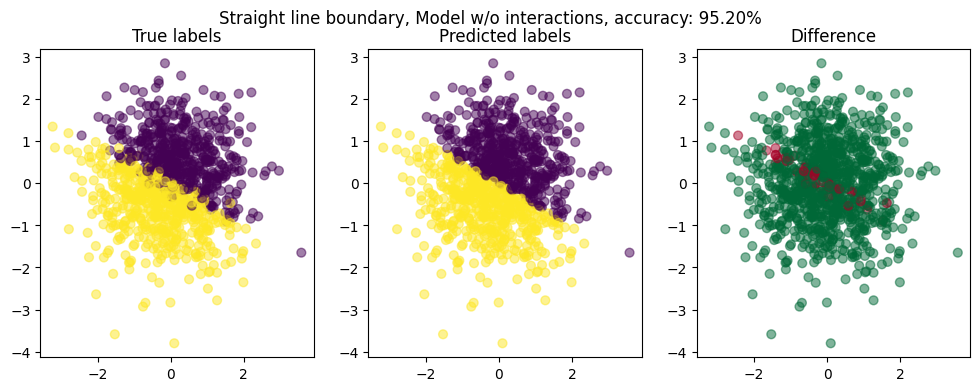

In [7]:
run_experiment(B=[0,1,2,0], title='Straight line boundary, Model w/o interactions', seed=123)

### Model with interactions

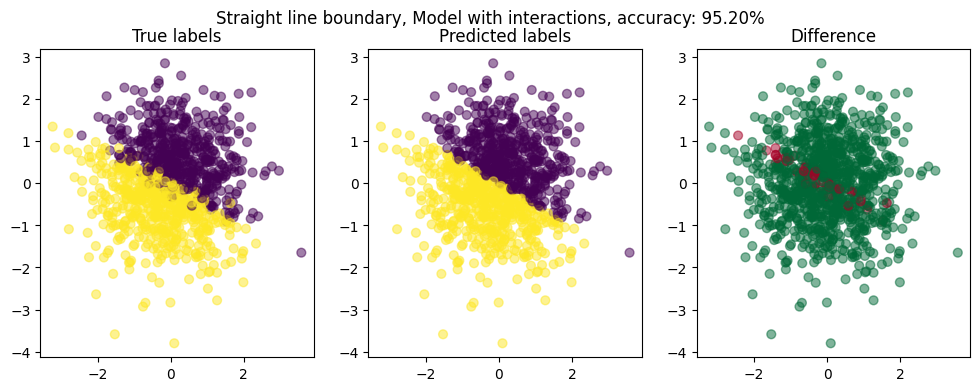

In [8]:
run_experiment(B=[0,1,2,0], interactions = True, title='Straight line boundary, Model with interactions', seed=123)

## Experiment 2 - Data with interactions

### Model without interactions

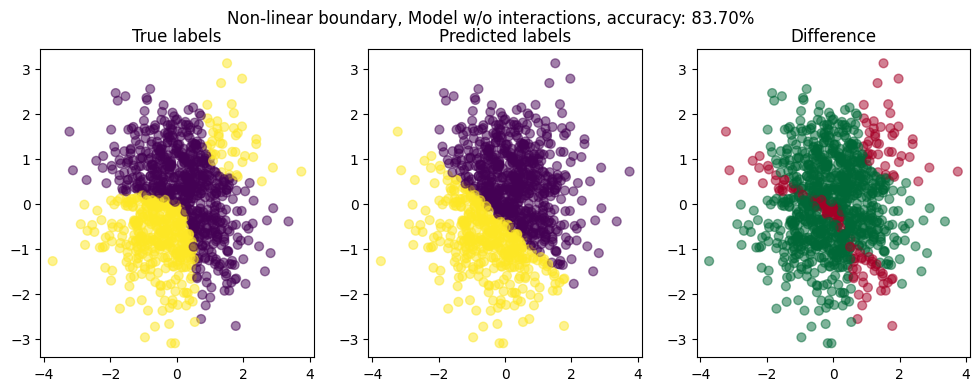

In [9]:
run_experiment(B=[0,1,2,-3], title='Non-linear boundary, Model w/o interactions', seed=234)

### Model with interactions

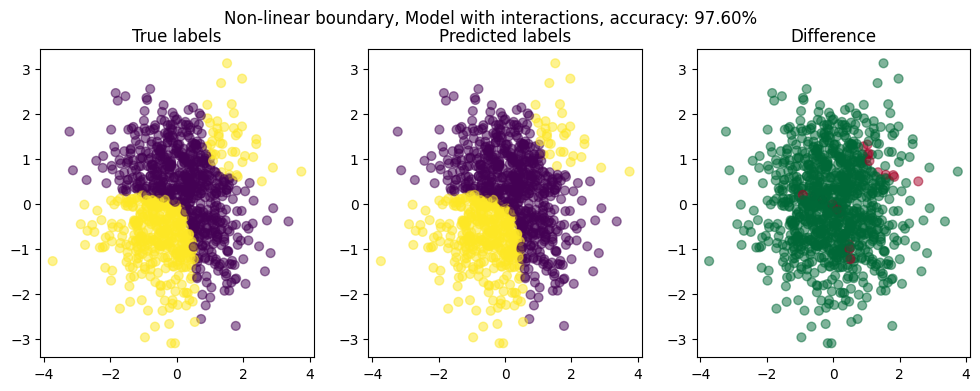

In [10]:
run_experiment(B=[0,1,2,-3], interactions = True, title='Non-linear boundary, Model with interactions', seed=234)

## Experiment 3 - XOR problem

### Model without interactions

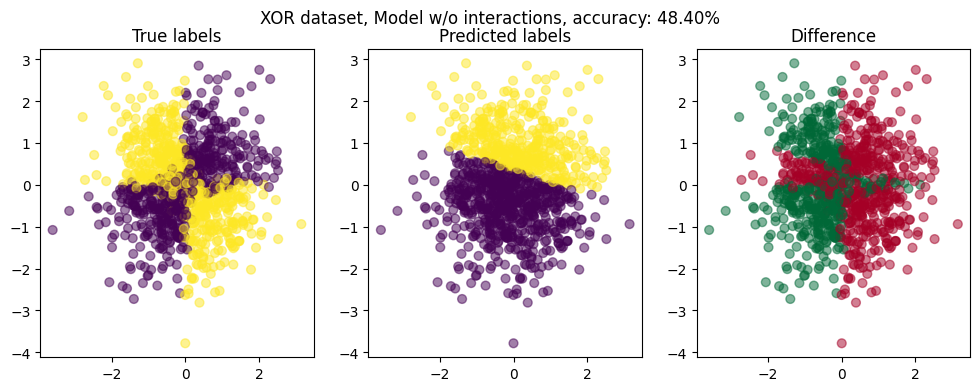

In [11]:
run_experiment(B=[0,0,0,1], title='XOR dataset, Model w/o interactions', seed=345)

### Model with interactions

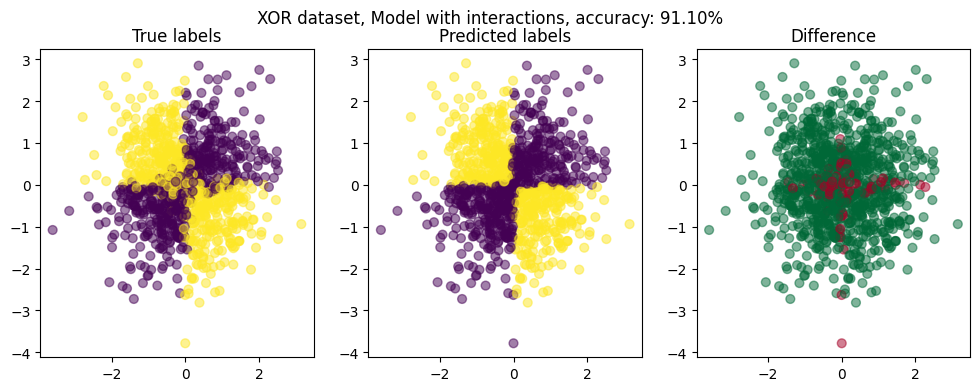

In [12]:
run_experiment(B=[0,0,0,1], interactions = True, title='XOR dataset, Model with interactions', seed=345)

## Experiment 4 - L2 regularization decreases betas

In [13]:
X, Y = generate_data([0,1,2,0], seed=456)

def get_experiment_results(X, Y, l2=0):
    lr = LR()
    lr.fit(X,Y, l2=l2)
    betas = lr.beta.flatten()
    result = np.array([betas[0], betas[1], betas[2], 1-np.mean(np.abs(lr.predict(X)-Y))])
    return result

unregularized = get_experiment_results(X,Y, l2=0)
regularized = get_experiment_results(X,Y, l2=10000)

results_df = pd.DataFrame(data=np.transpose([regularized.flatten(), unregularized.flatten()]), 
                          columns=['Regularized', 'Unregularized'], 
                          index=['Intercept', 'X1', 'X2', 'Accuracy'])
results_df

/mnt/Data/studies/py_projects/aml_project/Logistic-Regression-with-IRLS/LogisticRegressionIRLS.py:46: ConvergenceWarning: Algorithm didn't converge! Iteration limit reached!
  warnings.warn("Algorithm didn't converge! Iteration limit reached!", ConvergenceWarning)


,Regularized,Unregularized
Intercept,0.058517,0.206766
X1,0.954011,5.608639
X2,1.945914,10.886756
Accuracy,0.958000,0.961000


## Experiment 5 - Training process visualization

Here, there we modify our implementation to allow for visualization of the training process. This will allow us to see the change in decision boundary.

In [123]:
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd

class LR():
    def __init__(self, X, Y, interactions = [], maximisation_minorisation = False, seed=123):
        # X- DataFrame of predictors
        # Y- matrix of target variable of shape N x 1
        # interactions- a matrix with two columns, in which each row specifies a pair of variables between which we want to consider interactions
        
        self.seed=seed
        np.random.seed(seed)
        self.X = np.c_[np.ones(X.shape[0]) , X.values]
        self.Y = Y
        self.interactions = interactions
        for interaction in interactions:
            self.X=np.c_[self.X, self.X[:,interaction[0]+1] * self.X[:,interaction[1]+1]]
        self.β_new = np.transpose([[np.random.uniform() for _ in range(self.X.shape[1])]]) #Beta initialisation
        self.beta = self.β_new
        self.maximisation_minorisation = maximisation_minorisation
        
    def sigmoid(self, X, β):
        return 1/(1+np.exp(X @ β))

    def fit(self, iter_max = 100, l2=0): 

        # iter_max- maximum number of iterations 
        # l2- ridge regularization strength
        
        i=0
        while (i < iter_max and (i == 0 or np.sum(np.abs(self.β_new-β_old))>1e-4)): #Stopping if betas don't change or reached iteration limit
            i+=1
            β_old = self.β_new
            π = self.sigmoid(self.X, β_old)
            W = [1/4 for i in range(self.X.shape[0])] if self.maximisation_minorisation else np.transpose((π*(1-π)))[0]
            
            #Stopping when W approaches singularity
            if 1-self.maximisation_minorisation and np.min(W)<1e-20: 
                break
            
            W = np.diag(W)
            H = np.transpose(self.X) @ W @ self.X
            grad = np.transpose(self.X) @ (Y-π) 
            self.β_new = β_old - np.linalg.inv(H + l2*np.eye(H.shape[0])) @ grad
        self.beta = self.β_new

    def predict(self, X, p=1/2):
        X_exp = np.c_[np.ones(X.shape[0]) , X.values]
        for interaction in self.interactions:
            X_exp=np.c_[X_exp, X_exp[:,interaction[0]+1] * X_exp[:,interaction[1]+1]]
        return (self.sigmoid(X_exp,self.beta)>p).astype(int)

In [124]:
# create a sparse XOR dataset
N = 40
np.random.seed(12)
X = np.r_[np.random.randn(int(N/4),2)/2.5 - [1,1], np.random.randn(int(N/4),2)/2.5 + [1,1], np.random.randn(int(N/4),2)/2.5 + [1,-1], np.random.randn(int(N/4),2)/2.5 - [1,-1]]
Y = np.r_[np.zeros((2*int(N/4),1)), np.ones((2*int(N/4),1))].reshape(-1,1)
X = pd.DataFrame(X, columns=['X1', 'X2'])

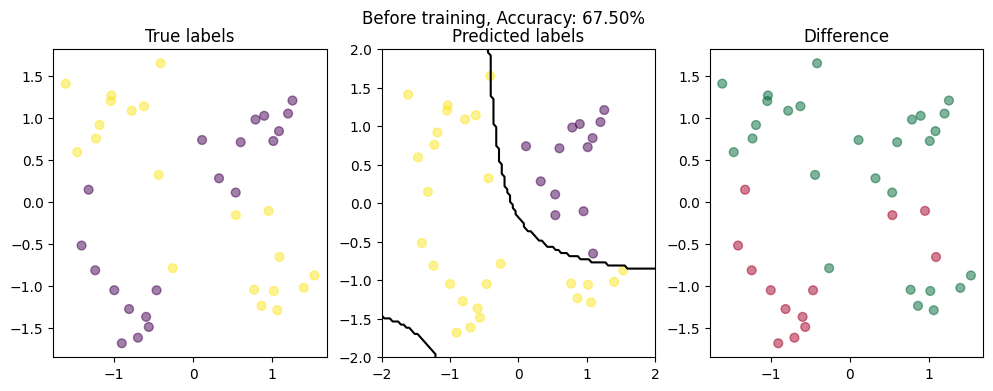

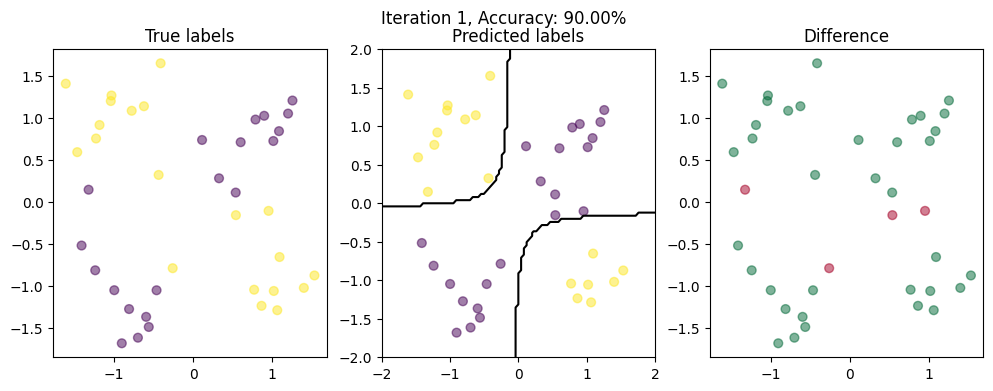

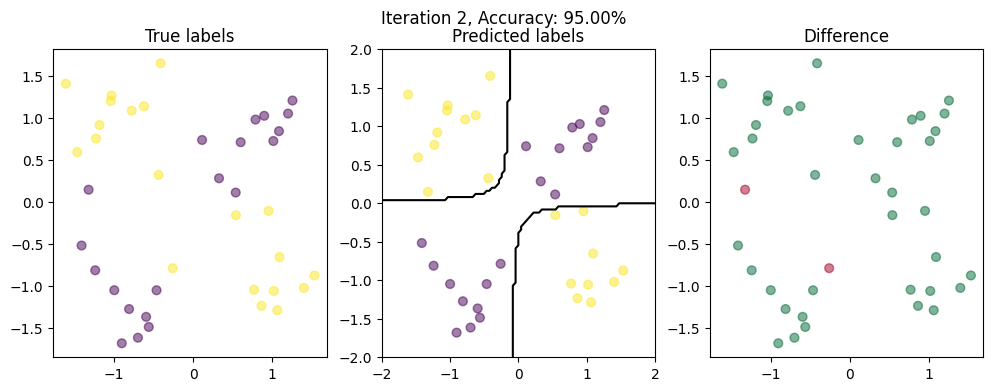

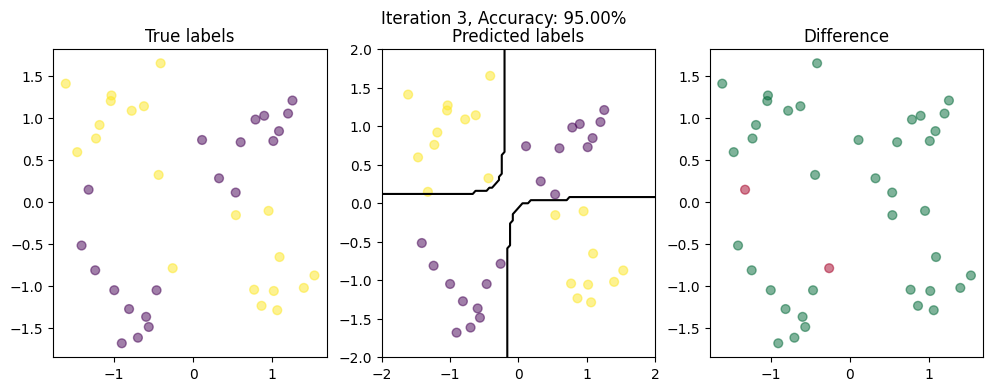

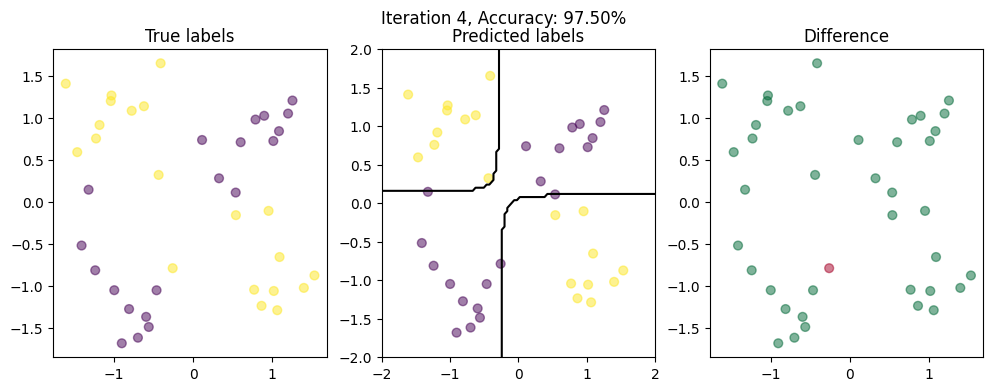

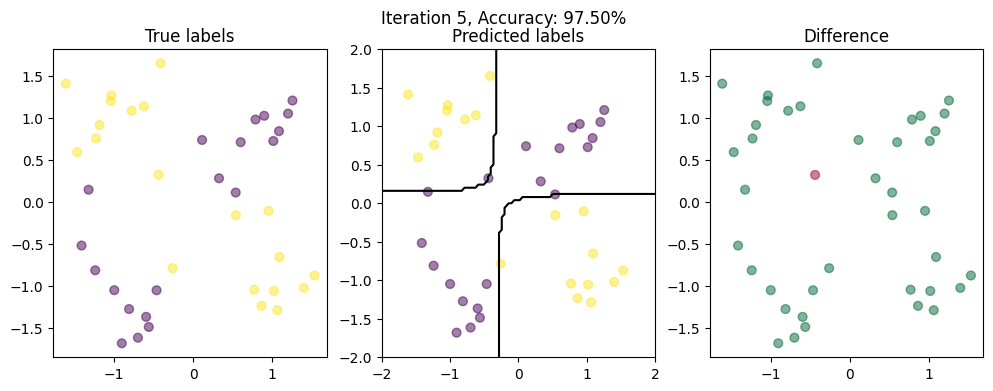

In [129]:
def add_decision_boundary(ax, lr):
    # add decision boundary
    x1 = np.linspace(-2, 2, 100)
    x2 = np.linspace(-2, 2, 100)
    x1, x2 = np.meshgrid(x1, x2)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    X_exp = np.c_[np.ones(x1.shape[0]) , x1, x2]
    for interaction in lr.interactions:
        X_exp=np.c_[X_exp, X_exp[:,interaction[0]+1] * X_exp[:,interaction[1]+1]]
    x1 = x1.reshape(100,100)
    x2 = x2.reshape(100,100)
    x3 = (lr.sigmoid(X_exp, lr.beta)>0.5).astype(int).reshape(100,100)

    ax[1].contour(x1, x2, x3, levels=[0.5], colors='k', linestyles='solid')
    
STEPS = 5
ITERATIONS_PER_STEP = 1

lr = LR(X,Y, interactions = [[0,1]], seed=7)
y_pred =  lr.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
add_decision_boundary(ax, lr)
ax[0].scatter(X['X1'], X['X2'], c=Y, alpha=0.5, s=40)
ax[0].set_title('True labels')
ax[1].scatter(X['X1'], X['X2'], c=y_pred, alpha=0.5, s=40)
ax[1].set_title('Predicted labels')
ax[2].scatter(X['X1'], X['X2'], c=-np.abs(y_pred-Y), cmap='RdYlGn', s=40, alpha=0.5)
ax[2].set_title('Difference')
accuracy = 1-np.mean(np.abs(y_pred-Y))
fig.suptitle(f'Before training, Accuracy: {accuracy  :.2%}')    
fig.savefig('training_iter_0.png', dpi=300, bbox_inches='tight')
plt.show()


for i in range(STEPS):

    lr.fit(iter_max=ITERATIONS_PER_STEP, l2=0)
    y_pred =  lr.predict(X)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    add_decision_boundary(ax, lr)
    ax[0].scatter(X['X1'], X['X2'], c=Y, alpha=0.5, s=40)
    ax[0].set_title('True labels')
    ax[1].scatter(X['X1'], X['X2'], c=y_pred, alpha=0.5, s=40)
    ax[1].set_title('Predicted labels')
    ax[2].scatter(X['X1'], X['X2'], c=-np.abs(y_pred-Y), cmap='RdYlGn', s=40, alpha=0.5)
    ax[2].set_title('Difference')
    accuracy = 1-np.mean(np.abs(y_pred-Y))
    fig.suptitle(f'Iteration {ITERATIONS_PER_STEP*(i+1)}, Accuracy: {accuracy  :.2%}')    
    fig.savefig(f'training_iter_{ITERATIONS_PER_STEP*(i+1)}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Simulation experiments results

Experiment results match the expectations:
1. Algorithm can learn a linearly separable dataset with close to 100% accuracy. 
2. Algorithm can learn a non-linearly separable dataset with close to 100% accuracy when interactions are included. Without them, the accuracy is lower, around 83%. The decision boundary is a straight line when interactions are not included (incorrect for this dataset, as expected), and a curved line when they are included.
3. Algorithm can learn XOR dataset with close to 100% accuracy when interactions are included. Without them, the accuracy is around 50%.
4. L2 regularization decreases betas with little effect on accuracy, as expected.
5. Decision boundary is updated after each iteration. Accuracy increases at the beginning and then stabilises while decision boundaries move slightly around the optimal solution. 